In [1023]:
# Feel free to change / extend / adapt this source code as needed to complete the homework, based on its requirements.
# This code is given as a starting point.
#
# REFEFERENCES
# The code is partly adapted from pytorch tutorials, including https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# ---- hyper-parameters ----
# You should tune these hyper-parameters using:
# (i) your reasoning and observations, 
# (ii) by tuning it on the validation set, using the techniques discussed in class.
# You definitely can add more hyper-parameters here.
batch_size = 8
max_num_epoch = 300
hps = {'lr':0.01}

# ---- options ----
DEVICE_ID = 'cpu' # set to 'cpu' for cpu, 'cuda' / 'cuda:0' or similar for gpu.
LOG_DIR = 'checkpoints'
VISUALIZE = False # set True to visualize input, prediction and the output from the last batch
LOAD_CHKPT = False

In [1024]:
# --- imports ---
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import hw3utils

In [1025]:
torch.multiprocessing.set_start_method('spawn', force=True)

In [1026]:
# ---- utility functions -----
def get_loaders(batch_size,device):
    data_root = 'ceng483-hw3-dataset' 
    train_set = hw3utils.HW3ImageFolder(root=os.path.join(data_root,'train'),device=device)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    val_set = hw3utils.HW3ImageFolder(root=os.path.join(data_root,'val'),device=device)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
    # Note: you may later add test_loader to here.
    return train_loader, val_loader

In [1028]:
class AccuracyLoss(nn.Module):
    def __init__(self, error_margin=12):
        super(AccuracyLoss, self).__init__()
        self.error_margin = error_margin

    def forward(self, ground_truth, prediction):
        # Ensure the images have the same shape
        assert ground_truth.shape == prediction.shape, "Ground truth and prediction shapes must match"
        
        # Convert to PyTorch tensors
        ground_truth = 255*(ground_truth+1)/2
        ground_truth = ground_truth.view(-1).long()
        prediction = 255*(prediction+1)/2
        prediction = prediction.view(-1).long()
        
        # Compute the accuracy
        cur_acc = torch.sum(torch.abs(ground_truth - prediction) < self.error_margin).float() / ground_truth.shape[0]

        # Compute the ratio of correctly estimated pixels to all pixels
        return 1.0 - cur_acc  # Returning 1.0 - accuracy as a loss


In [1029]:
# ---- ConvNet -----
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Decoder
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),  # Adding ReLU activation after BatchNorm
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
            )
            

    def forward(self, x):
        x = self.model(x)
        return x

In [1030]:
# ---- training code -----
device = torch.device(DEVICE_ID)
print('device: ' + str(device))
net = Net().to(device=device)
criterion = nn.MSELoss()
criteriontwo = AccuracyLoss()
optimizer = optim.SGD(net.parameters(), lr=hps['lr'])
train_loader, val_loader = get_loaders(batch_size,device)

min_valid_loss = np.inf

'''if LOAD_CHKPT:
    print('loading the model from the checkpoint')
    model.load_state_dict(os.path.join(LOG_DIR,'checkpoint.pt'))'''

print('training begins')

hist_train = []
hist_val = []

hist_acc = []

early_stopping_patience = 10
best_val_loss = float('inf')
current_patience = 0
improvement_threshold=0.1


for epoch in range(max_num_epoch):  
    running_loss = 0.0 # training loss of the network
    valid_loss = 0.0
    running_acc = 0.0
    for iteri, data in enumerate(train_loader, 0):
        inputs, targets = data # inputs: low-resolution images, targets: high-resolution images.

        optimizer.zero_grad() # zero the parameter gradients

        # do forward, backward, SGD step
        preds = net(inputs)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        

        '''# print loss
        
        print_n = 100 # feel free to change this constant
        if iteri % print_n == (print_n-1):    # print every print_n mini-batches
            print('[%d, %5d] network-loss: %.3f' %
                  (epoch + 1, iteri + 1, running_loss / 100))
            running_loss = 0.0
            # note: you most probably want to track the progress on the validation set as well (needs to be implemented)'''

        if (iteri==0) and VISUALIZE: 
            hw3utils.visualize_batch(inputs,preds,targets)

    ### CHANGE ----------------
            
    for iteri,data in enumerate(val_loader,0):
        inputs,targets = data

        prediction = net(inputs)

        vloss = criterion(prediction,targets)
        vacc = criteriontwo(prediction,targets)
        valid_loss += vloss.item() * inputs.size(0)
        running_acc += vacc.item() * inputs.size(0)
        
    ### CHANGE ----------------
        
    hist_train.append(running_loss/len(train_loader))
    hist_val.append(valid_loss / len(val_loader))
    hist_acc.append(running_acc/len(val_loader))

    val_loss = valid_loss / len(val_loader)

    if val_loss < (1 - improvement_threshold) * best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= early_stopping_patience:
            print(f"Early stopping after {epoch + 1} epochs.")
            break
        
    print(f'Epoch {epoch+1} \t\t Training Loss: {running_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)} \t\t Accuracy Loss: {running_acc/len(val_loader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss


    print('Saving the model, end of epoch %d' % (epoch+1))
    if not os.path.exists(LOG_DIR):
        os.makedirs(LOG_DIR)
    torch.save(net.state_dict(), os.path.join(LOG_DIR,'checkpoint5.pt'))
    #hw3utils.visualize_batch(inputs,preds,targets,os.path.join(LOG_DIR,'example.png'))

print('Finished Training')


device: cpu
training begins
Epoch 1 		 Training Loss: 0.051330359901090306 		 Validation Loss: 0.13192280754446983 		 Accuracy Loss: 3.1920020847320556
Validation Loss Decreased(inf--->32.980702) 	 Saving The Model
Saving the model, end of epoch 1
Epoch 2 		 Training Loss: 0.015466739783605066 		 Validation Loss: 0.11991496992111206 		 Accuracy Loss: 2.989938533782959
Validation Loss Decreased(32.980702--->29.978742) 	 Saving The Model
Saving the model, end of epoch 2
Epoch 3 		 Training Loss: 0.01431455910905077 		 Validation Loss: 0.11267004364728928 		 Accuracy Loss: 2.8518762226104735
Validation Loss Decreased(29.978742--->28.167511) 	 Saving The Model
Saving the model, end of epoch 3
Epoch 4 		 Training Loss: 0.01355975817743177 		 Validation Loss: 0.10740015482902526 		 Accuracy Loss: 2.7557702026367186
Validation Loss Decreased(28.167511--->26.850039) 	 Saving The Model
Saving the model, end of epoch 4
Epoch 5 		 Training Loss: 0.012966641608012704 		 Validation Loss: 0.10316841

In [1038]:
print(min(hist_train))
print(min(hist_val))

0.010102706802889895
0.0822039985358715


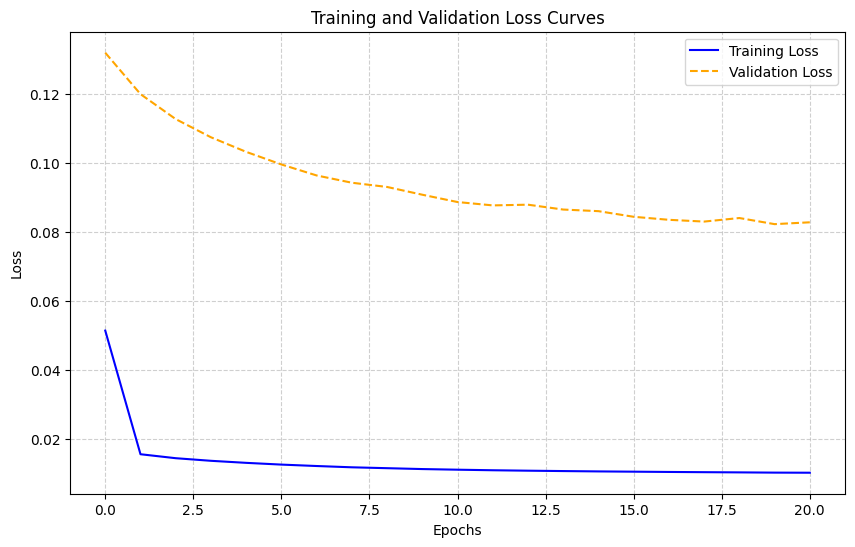

In [1032]:
import matplotlib.pyplot as plt

# Assuming you have hist_train and hist_val lists for training and validation losses

# Plotting training and validation curves
plt.figure(figsize=(10, 6))

# Plot training loss with a solid line in blue
plt.plot(hist_train[:23], label='Training Loss', color='blue', linestyle='-')

# Plot validation loss with a dashed line in orange
plt.plot(hist_val[:23], label='Validation Loss', color='orange', linestyle='--')

# Add title and labels
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.6)

# Add legend
plt.legend()

# Save the plot as an image (optional)
plt.savefig('training_validation_curves.png')

# Show the plot
plt.show()


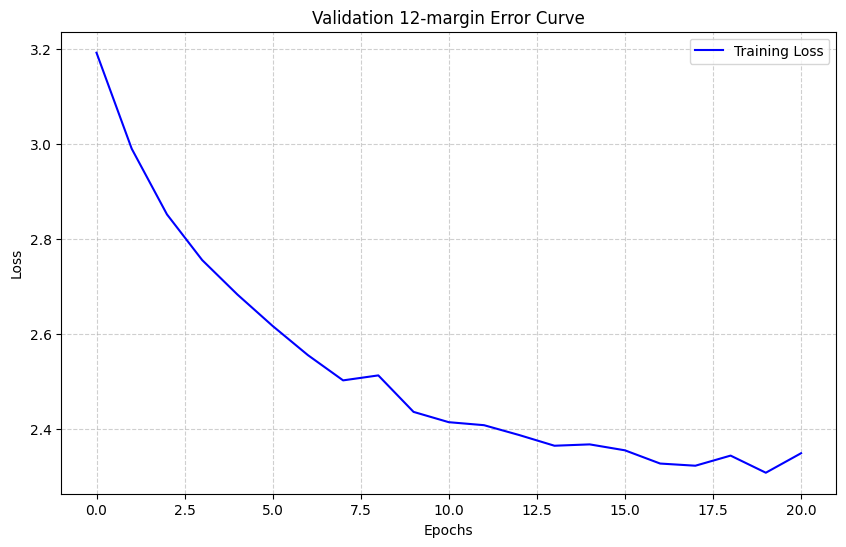

In [1039]:
# Plotting training and validation curves
plt.figure(figsize=(10, 6))

# Plot training loss with a solid line in blue
plt.plot(hist_acc, label='Training Loss', color='blue', linestyle='-')



# Add title and labels
plt.title('Validation 12-margin Error Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.6)

# Add legend
plt.legend()

# Save the plot as an image (optional)
plt.savefig('training_validation_curves.png')

# Show the plot

In [1021]:
def compute_accuracy(ground_truth, prediction, error_margin=12):
    # Ensure the images have the same shape
    assert ground_truth.shape == prediction.shape, "Ground truth and prediction shapes must match"
    prediction = prediction.reshape(-1).astype(np.int64)
    ground_truth = ground_truth.reshape(-1).astype(np.int64)
    cur_acc = (np.abs(ground_truth - prediction) < 12).sum() / ground_truth.shape[0]

    # Compute the ratio of correctly estimated pixels to all pixels
    
    return cur_acc

In [1069]:
from utils import read_image
predictions = []
gt = []
# Iterate over the dataset and make predictions
with torch.no_grad():
    for inputs, _ in val_loader:  # Assuming your dataloader provides inputs and labels
        outputs = net(inputs)
        predictions.append(outputs.numpy())  # Assuming outputs is a torch tensor
        gt.append(_.numpy())
gt = np.concatenate(gt, axis=0)
gt = ((gt + 1) / 2 * 255).astype(np.uint8)
gt = np.moveaxis(gt, 1, -1)

# Convert the list of predictions to a numpy array
predictions_np = np.concatenate(predictions, axis=0)
predictions_np = ((predictions_np + 1) / 2 * 255).astype(np.uint8)
predictions_np = np.moveaxis(predictions_np, 1, -1)


# Save predictions to npy file
np.save("estimations.npy", predictions_np)

acc = 0
max_acc = 0
for i in range(2000):

    ground_truth = gt[i]
    prediction = predictions_np[i]
    current = compute_accuracy(ground_truth,prediction)
    acc += current
    if current>max_acc:
        max_acc = current

print(max_acc)

acc /= 2000
print(f"{acc:.2f}/1.00")
    


0.9621354166666667
0.71/1.00


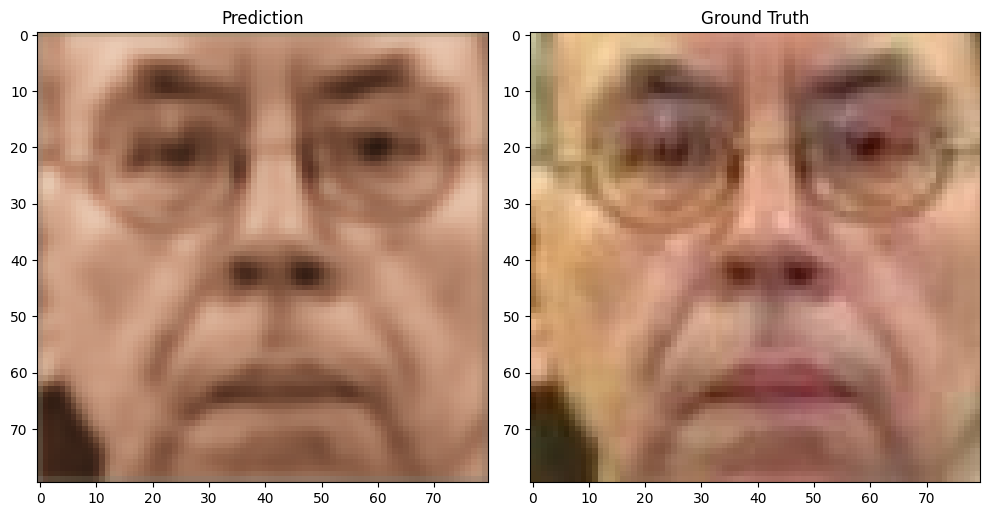

In [1071]:
import matplotlib.pyplot as plt
import numpy as np
sample = 0
# Assuming pred_img and gt_img are your prediction and ground truth images, each represented as NumPy arrays

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the prediction on the first subplot
axes[0].imshow(predictions_np[sample], cmap='gray')  # Use 'gray' colormap for grayscale images
axes[0].set_title('Prediction')

# Plot the ground truth on the second subplot
axes[1].imshow(gt[sample], cmap='gray')
axes[1].set_title('Ground Truth')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

In [1059]:
from skimage import io
def preprocess_image(image_path):
    # Read the image
    image = io.imread(image_path)

    # Convert to torch tensor and normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  # Adjust normalization values if needed
    ])
    input_tensor = transform(image)

    # Add batch dimension
    input_tensor = input_tensor.unsqueeze(0)

    return input_tensor

In [1065]:
folder_path = "images_grayscale"

# Get a list of all files in the folder
all_files = os.listdir(folder_path)

# Filter out only image files (you may need to customize the image file extensions)
image_files = [file for file in all_files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
estimations = []
for image_path in image_files:
    # Preprocess the image
    input_tensor = preprocess_image("images_grayscale/"+image_path)

    # Make inference
    with torch.no_grad():
        output = net(input_tensor)
        estimations.append(output.numpy())

# Convert the list of predictions to a numpy array
predictions_np = np.concatenate(estimations, axis=0)
predictions_np = ((predictions_np + 1) / 2 * 255).astype(np.uint8)
predictions_np = np.moveaxis(predictions_np, 1, -1)


print(predictions_np.shape)

print(image_files)

(2000, 80, 80, 3)
['63.jpg', '823.jpg', '1409.jpg', '189.jpg', '77.jpg', '837.jpg', '1353.jpg', '1435.jpg', '1421.jpg', '1347.jpg', '638.jpg', '1390.jpg', '604.jpg', '162.jpg', '176.jpg', '88.jpg', '610.jpg', '1384.jpg', '1179.jpg', '1637.jpg', '1151.jpg', '1145.jpg', '1623.jpg', '1810.jpg', '1804.jpg', '348.jpg', '360.jpg', '406.jpg', '1192.jpg', '1186.jpg', '412.jpg', '1838.jpg', '374.jpg', '1019.jpg', '599.jpg', '1743.jpg', '1025.jpg', '1031.jpg', '1757.jpg', '228.jpg', '1964.jpg', '1970.jpg', '214.jpg', '1780.jpg', '1958.jpg', '572.jpg', '566.jpg', '1794.jpg', '200.jpg', '957.jpg', '1569.jpg', '943.jpg', '1227.jpg', '1541.jpg', '1555.jpg', '1233.jpg', '994.jpg', '758.jpg', '980.jpg', '770.jpg', '1582.jpg', '1596.jpg', '764.jpg', '1597.jpg', '765.jpg', '771.jpg', '1583.jpg', '981.jpg', '759.jpg', '995.jpg', '1554.jpg', '1232.jpg', '1226.jpg', '1540.jpg', '1568.jpg', '942.jpg', '956.jpg', '567.jpg', '201.jpg', '1795.jpg', '1959.jpg', '1781.jpg', '215.jpg', '573.jpg', '1971.jpg', '196

In [1068]:
np.save("estimations.npy", predictions_np)